In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.12.0

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 47.6 MB/s eta 0:00:00
  Attempting uninstall: ten

In [ ]:
# Common imports
import os
import numpy as np
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List
from shutil import copyfile

# Data Imports
import pandas as pd
from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls
import PIL

# Model Architecture
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, MobileNetV2, EfficientNetB7, Xception

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Analysis
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import Callback

In [ ]:
#Load Data

from google.colab import drive
drive.mount('/content/drive')

ORIGINAL_TRAIN_DIR = "/content/drive/MyDrive/Deep Learning Group Project/original_data/train"
ORIGINAL_TEST_DIR = "/content/drive/MyDrive/Deep Learning Group Project/original_data/test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the directory paths for the data (train , test , validate)
# Define root directory
root_dir = '/content/drive/MyDrive/Deep Learning Group Project/images/'
TRAINING_DIR =f"{root_dir}train/"  # path to the directory containing train  data
VALIDATION_DIR = f"{root_dir}valid/" # path to the directory containing validation data
TEST_DIR = f"{root_dir}test/" # path to the directory containing test data

try:
    os.mkdir(root_dir)
    os.mkdir(TRAINING_DIR)
    os.mkdir(VALIDATION_DIR)
    os.mkdir(TEST_DIR)
except FileExistsError:
    print("Dir Already Exists")

Dir Already Exists


In [ ]:
# Constants
IMAGE_SIZE = 160 # size of the input image
BATCH_SIZE = 32 # number of samples per gradient update
EPOCHS = 50 # number of epochs to train the model
NUM_CLASSES = 9 # number of classes at the dataset
SPLIT_SIZE = .8 # Define proportion of images used for training

# Model training
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['accuracy']

# Hyperparameters
LEARNING_RATE = 1e-3 # learning rate for the optimizer

# Random Seed
RANDOM_SEED = 48 # set random seed for reproducibility
os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) # set random seed for TensorFlow
np.random.seed(RANDOM_SEED) # set random seed for NumPy
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [ ]:
#  create_train_val_dirs
def create_train_val_dirs(root_path):

  os.mkdir(root_path)
  os.mkdir(root_path+'/train')
  os.mkdir(root_path+'/val')
  os.mkdir(root_path+'/train/Fish')
  os.mkdir(root_path+'/train/Goldfish')
  os.mkdir(root_path+'/train/Harbor seal')
  os.mkdir(root_path+'/train/Jellyfish')
  os.mkdir(root_path+'/train/Lobster')
  os.mkdir(root_path+'/train/Oyster')
  os.mkdir(root_path+'/train/Sea turtle')
  os.mkdir(root_path+'/train/Squid')
  os.mkdir(root_path+'/train/Starfish')

  os.mkdir(root_path+'/val/Fish')
  os.mkdir(root_path+'/val/Goldfish')
  os.mkdir(root_path+'/val/Harbor seal')
  os.mkdir(root_path+'/val/Jellyfish')
  os.mkdir(root_path+'/val/Lobster')
  os.mkdir(root_path+'/val/Oyster')
  os.mkdir(root_path+'/val/Sea turtle')
  os.mkdir(root_path+'/val/Squid')
  os.mkdir(root_path+'/val/Starfish')

In [ ]:
# Call create_train_val_dirs

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)
try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
    print("Error")

In [ ]:
# Test your create_train_val_dirs function
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/drive/MyDrive/Deep Learning Group Project/images/train
/content/drive/MyDrive/Deep Learning Group Project/images/val
/content/drive/MyDrive/Deep Learning Group Project/images/train/Fish
/content/drive/MyDrive/Deep Learning Group Project/images/train/Goldfish
/content/drive/MyDrive/Deep Learning Group Project/images/train/Harbor seal
/content/drive/MyDrive/Deep Learning Group Project/images/train/Jellyfish
/content/drive/MyDrive/Deep Learning Group Project/images/train/Lobster
/content/drive/MyDrive/Deep Learning Group Project/images/train/Oyster
/content/drive/MyDrive/Deep Learning Group Project/images/train/Sea turtle
/content/drive/MyDrive/Deep Learning Group Project/images/train/Squid
/content/drive/MyDrive/Deep Learning Group Project/images/train/Starfish
/content/drive/MyDrive/Deep Learning Group Project/images/val/Fish
/content/drive/MyDrive/Deep Learning Group Project/images/val/Goldfish
/content/drive/MyDrive/Deep Learning Group Project/images/val/Harbor seal
/content/

In [ ]:
# split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """

  files = []
  for filename in os.listdir(SOURCE_DIR):
      file = SOURCE_DIR + filename
      if os.path.getsize(file) > 0:
          files.append(filename)
      else:
          print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
      this_file = SOURCE_DIR + filename
      destination = TRAINING_DIR + filename
      copyfile(this_file, destination)

  for filename in testing_set:
      this_file = SOURCE_DIR + filename
      destination = VALIDATION_DIR + filename
      copyfile(this_file, destination)

In [ ]:
# Test your split_data function
# Define paths


Fish_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Fish/"
Goldfish_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Goldfish/"
Harbor_seal_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Harbor seal/"
Jellyfish_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Jellyfish/"
Lobster_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Lobster/"
Oyster_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Oyster/"
Sea_turtle_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Sea turtle/"
Squid_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Squid/"
Starfish_SOURCE_DIR = f"{ORIGINAL_TRAIN_DIR}/Starfish/"


TRAINING_DIR = "/content/drive/MyDrive/Deep Learning Group Project/images/train/"
VALIDATION_DIR = "/content/drive/MyDrive/Deep Learning Group Project/images/val/"
TRAINING_Fish_DIR = os.path.join(TRAINING_DIR, "Fish/")
VALIDATION_Fish_DIR = os.path.join(VALIDATION_DIR, "Fish/")
TRAINING_Goldfish_DIR = os.path.join(TRAINING_DIR, "Goldfish/")
VALIDATION_Goldfish_DIR = os.path.join(VALIDATION_DIR, "Goldfish/")
TRAINING_Harbor_seal_DIR = os.path.join(TRAINING_DIR, "Harbor seal/")
VALIDATION_Harbor_seal_DIR = os.path.join(VALIDATION_DIR, "Harbor seal/")
TRAINING_Jellyfish_DIR = os.path.join(TRAINING_DIR, "Jellyfish/")
VALIDATION_Jellyfish_DIR = os.path.join(VALIDATION_DIR, "Jellyfish/")
TRAINING_Lobster_DIR = os.path.join(TRAINING_DIR, "Lobster/")
VALIDATION_Lobster_DIR = os.path.join(VALIDATION_DIR, "Lobster/")
TRAINING_Oyster_DIR = os.path.join(TRAINING_DIR, "Oyster/")
VALIDATION_Oyster_DIR = os.path.join(VALIDATION_DIR, "Oyster/")
TRAINING_Sea_turtle_DIR = os.path.join(TRAINING_DIR, "Sea turtle/")
VALIDATION_Sea_turtle_DIR = os.path.join(VALIDATION_DIR, "Sea turtle/")
TRAINING_Squid_DIR = os.path.join(TRAINING_DIR, "Squid/")
VALIDATION_Squid_DIR = os.path.join(VALIDATION_DIR, "Squid/")
TRAINING_Starfish_DIR = os.path.join(TRAINING_DIR, "Starfish/")
VALIDATION_Starfish_DIR = os.path.join(VALIDATION_DIR, "Starfish/")

# Empty directories in case you run this cell multiple times

if len(os.listdir(TRAINING_Fish_DIR)) > 0:
  for file in os.scandir(TRAINING_Fish_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Goldfish_DIR)) > 0:
  for file in os.scandir(TRAINING_Goldfish_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Harbor_seal_DIR)) > 0:
  for file in os.scandir(TRAINING_Harbor_seal_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Jellyfish_DIR)) > 0:
  for file in os.scandir(TRAINING_Jellyfish_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Lobster_DIR)) > 0:
  for file in os.scandir(TRAINING_Lobster_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Oyster_DIR)) > 0:
  for file in os.scandir(TRAINING_Oyster_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Sea_turtle_DIR)) > 0:
  for file in os.scandir(TRAINING_Sea_turtle_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Squid_DIR)) > 0:
  for file in os.scandir(TRAINING_Squid_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_Starfish_DIR)) > 0:
  for file in os.scandir(TRAINING_Starfish_DIR):
    os.remove(file.path)

# Validation Dirs

if len(os.listdir(VALIDATION_Fish_DIR)) > 0:
  for file in os.scandir(VALIDATION_Fish_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Goldfish_DIR)) > 0:
  for file in os.scandir(VALIDATION_Goldfish_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Harbor_seal_DIR)) > 0:
  for file in os.scandir(VALIDATION_Harbor_seal_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Jellyfish_DIR)) > 0:
  for file in os.scandir(VALIDATION_Jellyfish_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Lobster_DIR)) > 0:
  for file in os.scandir(VALIDATION_Lobster_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Oyster_DIR)) > 0:
  for file in os.scandir(VALIDATION_Oyster_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Sea_turtle_DIR)) > 0:
  for file in os.scandir(VALIDATION_Sea_turtle_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Squid_DIR)) > 0:
  for file in os.scandir(VALIDATION_Squid_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_Starfish_DIR)) > 0:
  for file in os.scandir(VALIDATION_Starfish_DIR):
    os.remove(file.path)



# Run the function
split_data(Fish_SOURCE_DIR, TRAINING_Fish_DIR, VALIDATION_Fish_DIR, SPLIT_SIZE)
print(Fish_SOURCE_DIR)
print(TRAINING_Fish_DIR)
print(VALIDATION_Fish_DIR)
split_data(Goldfish_SOURCE_DIR , TRAINING_Goldfish_DIR, VALIDATION_Goldfish_DIR, SPLIT_SIZE)
split_data(Harbor_seal_SOURCE_DIR , TRAINING_Harbor_seal_DIR , VALIDATION_Harbor_seal_DIR, SPLIT_SIZE)
split_data(Jellyfish_SOURCE_DIR, TRAINING_Jellyfish_DIR, VALIDATION_Jellyfish_DIR, SPLIT_SIZE)
split_data(Lobster_SOURCE_DIR, TRAINING_Lobster_DIR, VALIDATION_Lobster_DIR, SPLIT_SIZE)
split_data(Oyster_SOURCE_DIR, TRAINING_Oyster_DIR, VALIDATION_Oyster_DIR, SPLIT_SIZE)
split_data(Sea_turtle_SOURCE_DIR, TRAINING_Sea_turtle_DIR, VALIDATION_Sea_turtle_DIR, SPLIT_SIZE)
split_data(Squid_SOURCE_DIR, TRAINING_Squid_DIR, VALIDATION_Squid_DIR, SPLIT_SIZE)
split_data(Starfish_SOURCE_DIR, TRAINING_Starfish_DIR, VALIDATION_Starfish_DIR, SPLIT_SIZE)



# Check that the number of images matches the expected output
# function should perform copies rather than moving images so original directories should contain unchanged images

# Training and validation splits
num_fish = len(os.listdir(Fish_SOURCE_DIR))
print(f"Original Fish's directory has {num_fish} images")
print(f"There are {len(os.listdir(TRAINING_Fish_DIR))} images of Fish for training")
print(f"There are {len(os.listdir(VALIDATION_Fish_DIR))} images of Fish for validation")
print('\n\n')

num_goldfish = len(os.listdir(Goldfish_SOURCE_DIR))
print(f"Original Goldfish's directory has {num_goldfish} images")
print(f"There are {len(os.listdir(TRAINING_Goldfish_DIR))} images of Goldfish for training")
print(f"There are {len(os.listdir(VALIDATION_Goldfish_DIR))} images of Goldfish for validation")
print('\n\n')

num_seal = len(os.listdir(Harbor_seal_SOURCE_DIR))
print(f"Original Harbor seal's directory has {num_seal} images")
print(f"There are {len(os.listdir(TRAINING_Harbor_seal_DIR))} images of Harbor seal for training")
print(f"There are {len(os.listdir(VALIDATION_Harbor_seal_DIR))} images of Harbor seal for validation")
print('\n\n')

num_jellyfish = len(os.listdir(Jellyfish_SOURCE_DIR))
print(f"Original Jellyfish's directory has {num_jellyfish} images")
print(f"There are {len(os.listdir(TRAINING_Jellyfish_DIR))} images of Jellyfish for training")
print(f"There are {len(os.listdir(VALIDATION_Jellyfish_DIR))} images of Jellyfish for validation")
print('\n\n')

num_lobster = len(os.listdir(Lobster_SOURCE_DIR))
print(f"Original Lobster's directory has {num_lobster} images")
print(f"There are {len(os.listdir(TRAINING_Lobster_DIR))} images of Lobster for training")
print(f"There are {len(os.listdir(VALIDATION_Lobster_DIR))} images of Lobster for validation")
print('\n\n')

num_oyster = len(os.listdir(Oyster_SOURCE_DIR))
print(f"Original Oyster's directory has {num_oyster} images")
print(f"There are {len(os.listdir(TRAINING_Oyster_DIR))} images of Oyster for training")
print(f"There are {len(os.listdir(VALIDATION_Oyster_DIR))} images of Oyster for validation")
print('\n\n')

num_turtle = len(os.listdir(Sea_turtle_SOURCE_DIR))
print(f"Original Sea turtle's directory has {num_turtle} images")
print(f"There are {len(os.listdir(TRAINING_Sea_turtle_DIR))} images of Sea turtle for training")
print(f"There are {len(os.listdir(VALIDATION_Sea_turtle_DIR))} images of Sea turtle for validation")
print('\n\n')

num_squid = len(os.listdir(Squid_SOURCE_DIR))
print(f"Original Squid's directory has {num_squid} images")
print(f"There are {len(os.listdir(TRAINING_Squid_DIR))} images of Squid for training")
print(f"There are {len(os.listdir(VALIDATION_Squid_DIR))} images of Squid for validation")
print('\n\n')

num_starfish = len(os.listdir(Starfish_SOURCE_DIR))
print(f"Original Starfish's directory has {num_starfish} images")
print(f"There are {len(os.listdir(TRAINING_Starfish_DIR))} images of Starfish for training")
print(f"There are {len(os.listdir(VALIDATION_Starfish_DIR))} images of Starfish for validation")
print('\n\n')

/content/drive/MyDrive/Deep Learning Group Project/original_data/train/Fish/
/content/drive/MyDrive/Deep Learning Group Project/images/train/Fish/
/content/drive/MyDrive/Deep Learning Group Project/images/val/Fish/
Original Fish's directory has 89 images
There are 71 images of Fish for training
There are 18 images of Fish for validation



Original Goldfish's directory has 65 images
There are 52 images of Goldfish for training
There are 13 images of Goldfish for validation



Original Harbor seal's directory has 46 images
There are 36 images of Harbor seal for training
There are 10 images of Harbor seal for validation



Original Jellyfish's directory has 85 images
There are 68 images of Jellyfish for training
There are 17 images of Jellyfish for validation



Original Lobster's directory has 39 images
There are 31 images of Lobster for training
There are 8 images of Lobster for validation



Original Oyster's directory has 62 images
There are 49 images of Oyster for training
There are

In [ ]:
#  train_val_generators
# data preprocessing
def train_val_generators(TRAINING_DIR, VALIDATION_DIR , TEST_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1./255.)  # Rescale pixel values to be between 0 and 1

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                      shuffle = True)

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1.0/255.) #set the rescale argument

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                shuffle = True)

  # Instantiate the ImageDataGenerator class  , For test datagenerator, we only normalize the data.
  test_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE))

  return train_generator, validation_generator, test_generator

In [ ]:
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR,ORIGINAL_TEST_DIR)

Found 494 images belonging to 9 classes.
Found 127 images belonging to 9 classes.
Found 185 images belonging to 9 classes.


In [ ]:
# Create X_train and y_train from the train_generator
X_train, y_train = next(train_generator)

# Create X_val and y_val from the val_generator
X_val, y_val = next(validation_generator)

In [ ]:
def create_model(backbone='Xception', learning_rate=0.0001, batch_size=32, dropout_rate=0.2):
    # Load the specified backbone architecture
    if backbone == 'Xception':
        backbone_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    else:
        raise ValueError("Invalid backbone architecture specified.")

    # Freeze the backbone layers
    backbone_model.trainable = False

    # Build the classification head on top of the backbone
    model = models.Sequential()
    model.add(backbone_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    # Compile the model
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)

<ipython-input-14-21447fe075c3>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)


In [ ]:
param_dist = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4]
}

In [ ]:
# Perform random search with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, verbose=2, n_iter=10)

# Create X_train and y_train from the train_generator
X_train, y_train = next(train_generator)

# Create X_val and y_val from the val_generator
X_val, y_val = next(validation_generator)

# Fit the model
random_search_result = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
83683744/83683744 [==============================] - 1s 0us/step


[CV] END batch_size=128, dropout_rate=0.3, learning_rate=0.001; total time=  51.2s


[CV] END batch_size=128, dropout_rate=0.3, learning_rate=0.001; total time=  49.8s


[CV] END batch_size=128, dropout_rate=0.3, learning_rate=0.001; total time=  47.7s


[CV] END batch_size=128, dropout_rate=0.3, learning_rate=0.0001; total time=  48.6s


[CV] END batch_size=128, dropout_rate=0.3, learning_rate=0.0001; total time=  49.0s


[CV] END batch_size=128, dropout_rate=0.3, learning_rate=0.0001; total time=  47.7s


[CV] END batch_size=32, dropout_rate=0.3, learning_rate=0.001; total time=  48.7s


[CV] END batch_size=32, dropout_rate=0.3, learning_rate=0.001; total time=  47.6s


[CV] END batch_size=32, dropout_rate=0.3, learning_rate=0.001; total time=  48.8s


[CV] END batch_size=64, dropout_rate=0.2, learning_rate=0.0001; total time=  49.3s


[CV] END batch_size=64, dropout_rate=0.2, learning_rate=0.0001; total time=  47.6s


[CV] END batch_size=64, dropout_rate=0.2, learning_rate=0.0001; total time=  49.2s


[CV] END batch_size=64, dropout_rate=0.2, learning_rate=0.001; total time=  49.3s


[CV] END batch_size=64, dropout_rate=0.2, learning_rate=0.001; total time=  30.4s


[CV] END batch_size=64, dropout_rate=0.2, learning_rate=0.001; total time=  49.5s


[CV] END batch_size=64, dropout_rate=0.4, learning_rate=0.01; total time=  29.3s


[CV] END batch_size=64, dropout_rate=0.4, learning_rate=0.01; total time=  47.6s


[CV] END batch_size=64, dropout_rate=0.4, learning_rate=0.01; total time=  48.5s


[CV] END batch_size=128, dropout_rate=0.2, learning_rate=0.0001; total time=  48.7s


[CV] END batch_size=128, dropout_rate=0.2, learning_rate=0.0001; total time=  49.0s


[CV] END batch_size=128, dropout_rate=0.2, learning_rate=0.0001; total time=  48.2s


[CV] END batch_size=128, dropout_rate=0.2, learning_rate=0.01; total time=  48.6s


[CV] END batch_size=128, dropout_rate=0.2, learning_rate=0.01; total time=  48.5s


[CV] END batch_size=128, dropout_rate=0.2, learning_rate=0.01; total time=  47.7s


[CV] END batch_size=32, dropout_rate=0.2, learning_rate=0.01; total time=  48.8s


[CV] END batch_size=32, dropout_rate=0.2, learning_rate=0.01; total time=  48.8s


[CV] END batch_size=32, dropout_rate=0.2, learning_rate=0.01; total time=  49.2s


[CV] END batch_size=64, dropout_rate=0.4, learning_rate=0.0001; total time=  49.0s


[CV] END batch_size=64, dropout_rate=0.4, learning_rate=0.0001; total time=  48.0s


[CV] END batch_size=64, dropout_rate=0.4, learning_rate=0.0001; total time=  49.3s


In [ ]:
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

Best: 0.715152 using {'learning_rate': 0.01, 'dropout_rate': 0.4, 'batch_size': 64}


In [ ]:
best_model = create_model(backbone='Xception', learning_rate=0.01, batch_size=64, dropout_rate=0.4)
best_model.fit(train_generator, epochs=30)
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/30
16/16 [==============================] - 70s 4s/step - loss: 1.5519 - accuracy: 0.4879
Epoch 2/30
16/16 [==============================] - 59s 4s/step - loss: 0.8099 - accuracy: 0.7530
Epoch 3/30
16/16 [==============================] - 59s 4s/step - loss: 0.5722 - accuracy: 0.8300
Epoch 4/30
16/16 [==============================] - 58s 4s/step - loss: 0.4379 - accuracy: 0.8664
Epoch 5/30
16/16 [==============================] - 60s 4s/step - loss: 0.3327 - accuracy: 0.9028
Epoch 6/30
16/16 [==============================] - 58s 4s/step - loss: 0.2648 - accuracy: 0.9372
Epoch 7/30
16/16 [==============================] - 60s 4s/step - loss: 0.2279 - accuracy: 0.9433
Epoch 8/30
16/16 [==============================] - 58s 4s/step - loss: 0.1498 - accuracy: 0.9696
Epoch 9/30
16/16 [==============================] - 61s 4s/step - loss: 0.1402 - accuracy: 0.9615
Epoch 10/30
16/16 [==============================] - 58s 4s/step - loss: 0.1151 - accuracy: 0.9737
Epoch 11/30
16/16 [

In [ ]:
predicted_labels = best_model.predict(test_generator)
predicted_labels = np.argmax(predicted_labels, axis=1)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

6/6 [==============================] - 26s 4s/step


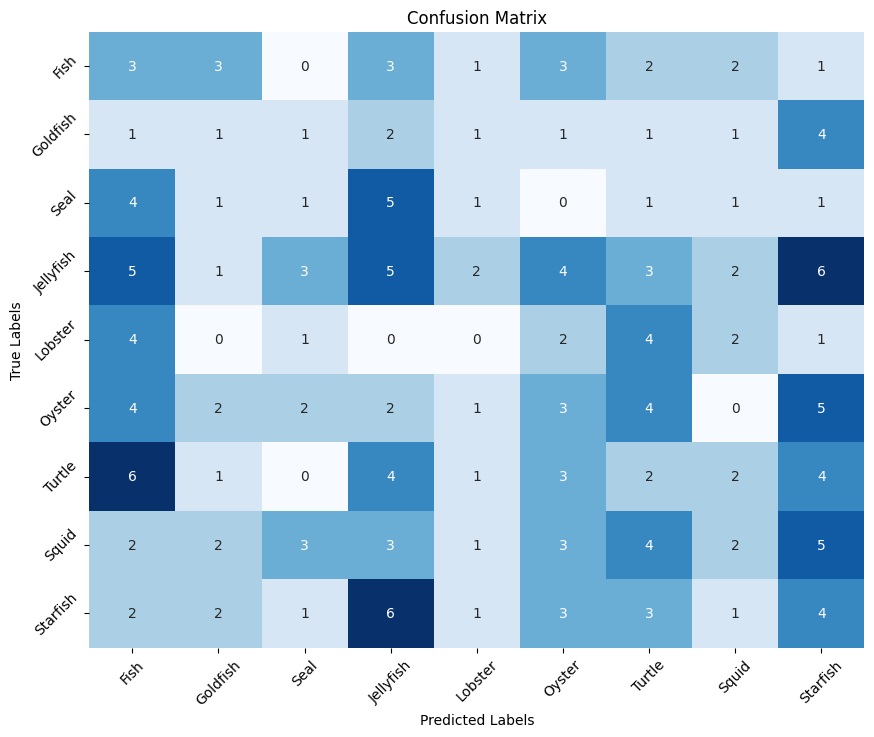

In [ ]:
labels = ['Fish', 'Goldfish', 'Seal', 'Jellyfish', 'Lobster', 'Oyster', 'Turtle', 'Squid', 'Starfish']

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

Epoch 1/30
16/16 [==============================] - 87s 5s/step - loss: 0.0317 - accuracy: 0.9899 - val_loss: 1.1144 - val_accuracy: 0.7008
Epoch 2/30
16/16 [==============================] - 75s 5s/step - loss: 0.0200 - accuracy: 0.9980 - val_loss: 1.1167 - val_accuracy: 0.7008
Epoch 3/30
16/16 [==============================] - 79s 5s/step - loss: 0.0215 - accuracy: 0.9960 - val_loss: 1.1480 - val_accuracy: 0.7087
Epoch 4/30
16/16 [==============================] - 74s 5s/step - loss: 0.0291 - accuracy: 0.9899 - val_loss: 1.1880 - val_accuracy: 0.7165
Epoch 5/30
16/16 [==============================] - 80s 5s/step - loss: 0.0274 - accuracy: 0.9939 - val_loss: 1.1097 - val_accuracy: 0.6929
Epoch 6/30
16/16 [==============================] - 73s 5s/step - loss: 0.0293 - accuracy: 0.9919 - val_loss: 1.2173 - val_accuracy: 0.7008
Epoch 7/30
16/16 [==============================] - 81s 5s/step - loss: 0.0533 - accuracy: 0.9818 - val_loss: 1.1478 - val_accuracy: 0.6850
Epoch 8/30
16/16 [==

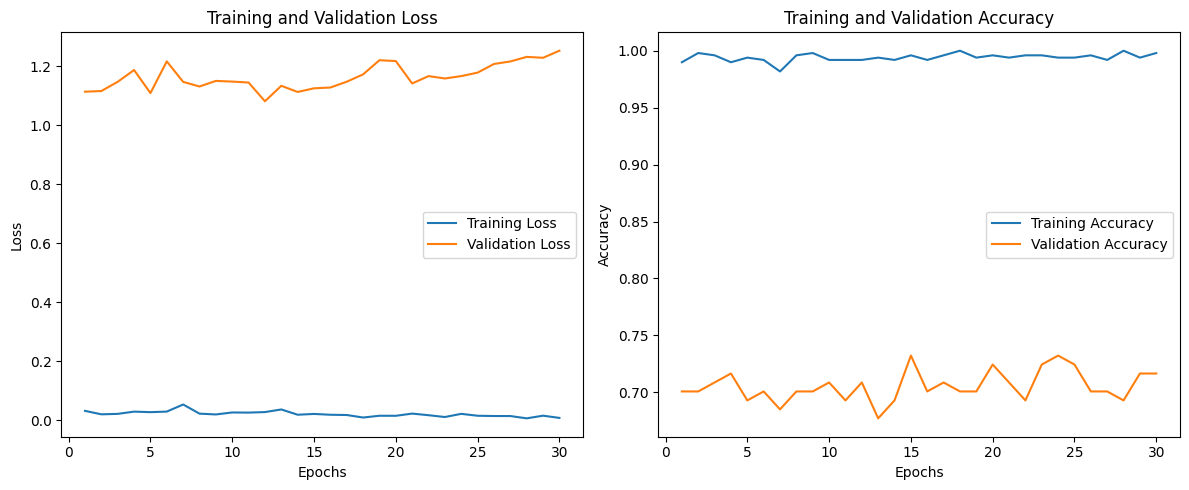

In [ ]:
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.train_accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

metrics_callback = MetricsCallback()
history = best_model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[metrics_callback])

epochs = range(1, len(metrics_callback.train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, metrics_callback.train_loss, label='Training Loss')
plt.plot(epochs, metrics_callback.val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, metrics_callback.train_accuracy, label='Training Accuracy')
plt.plot(epochs, metrics_callback.val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()